# Identify the correct dictionary, vector space, and metric used in Contexto.me

## Intro

In order to create an efficient search algorithm, it must be informed with an embedding 
space that resembles the one used by the creators of the game.

On top of that, the embedding space should at least include all the target words for all
the games in Contexto.me

According to the Credits of the game, Standford's GloVe embeddings were used

![Credits](img/Credits.png)

There are multiple pretrained options in the linked Standford's webpage:

https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip

https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip

https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip

https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip

On top of that there are multiple possible distances to find nearest neighbors
(e.g COSINE, EUCLID, DOT, MANHATTAN) and this is also not specified by the authors.

Luckily after some thinkering, I found out that it is possible to obtain the highest 
500 words for each game by using GET machado/top/{game_id}

This information can be used to identify the best embedding space.

## Approach

Measure the rank correlation of multiple possible embedding spaces with the words for a 
game.

## Download the data

In [8]:
# beware this uses >10GB of disk space
DOWNLOAD = False

if DOWNLOAD:
    links = [
        "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.42B.300d.zip",
        "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip",
        "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip",
        "https://huggingface.co/stanfordnlp/glove/resolve/main/glove.twitter.27B.zip",
        "https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-19.08.txt.gz",
    ]
    # download to data folder
    for link in links:
        !wget $link -O data/
    # unzip the files
    !unzip data/glove.42B.300d.zip -d data/
    !unzip data/glove.840B.300d.zip -d data/
    !unzip data/glove.6B.zip -d data/
    !unzip data/glove.twitter.27B.zip -d data/
    !gunzip data/numberbatch-19.08.txt.gz
else:
    print("Skipping download.")

Skipping download


## Measure correlation of NN

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
from api import ContextoApiClient
import pandas as pd

client = ContextoApiClient()



In [36]:
from environment import GloVeData
from qdrant_client import QdrantClient
from qdrant_client.models import Distance,VectorParams

In [39]:
from scipy.stats import kendalltau
def check_correlation(game_id, distance_metric: Distance, glove_fp: str, embedding_size: int):
    
    # get the top words for the game
    top_words = client.top_words(game_id)
    print("Top words:", top_words[:10])
    top_words_fp = "top_words.txt"
    with open(top_words_fp, "w") as f:
        f.write("\n".join(top_words))

    # build a the vector space
    qdrant = QdrantClient(":memory:")

    if glove_fp == "word2vec-google-news-300":
        # added after the highest correlation was found to be only kendall tau 0.58 (glove 42B 300d)
        import gensim.downloader 
        from qdrant_client.models import VectorParams, PointStruct
        w2v = gensim.downloader.load("word2vec-google-news-300")
        vectors_dict = {word: w2v[word] for word in top_words if word in w2v}

        # build the vector space
        qdrant = QdrantClient(":memory:")
        qdrant.create_collection(collection_name="glove", vectors_config=VectorParams(size=embedding_size, distance=Distance.COSINE))

        qdrant.upsert("glove", points=[
                PointStruct(id=idx, vector=vec.tolist(), payload={"word":word, "in_game":True, "game_distance":0}) 
                for idx, (word, vec) in enumerate(vectors_dict.items())
            ])

    else:
        GloVeData.build(qdrant, glove_fp, top_words_fp, distance_metric, embedding_size)

    # get the nearest words to the target word
    glove_sorted = GloVeData.nearest_by_word(qdrant, top_words[0], limit=500)

    # get the index of  the glove sorted in the top words
    indices = {word: i for i, word in enumerate(top_words)}
    glove_sorted_indices = [indices[word] for word in glove_sorted if word in indices]
    n_found = len(glove_sorted_indices)
    
    print("Glove sorted:", glove_sorted[:10])

    # measure kendall tau distance between the sorted list and the top words
    tau, p = kendalltau(list(indices.values())[:n_found], glove_sorted_indices)

    # return the results
    params_results = {
        "game_id": game_id,
        "distance_metric": distance_metric,
        "glove_fp": glove_fp,
        "top_words": top_words[:10],
        "sorted_words": glove_sorted[:10],
        "kendall_tau": tau,
        "p_value": p
    }
    qdrant.close()
    return params_results


In [ ]:
# Run the experiments

game_ids = [1,2,3,4,5]
distance_metrics = [Distance.COSINE, Distance.EUCLID, Distance.DOT, Distance.MANHATTAN]
glove_fps = [
    ("data/numberbatch-en-19.08.txt", 300),
    ("word2vec-google-news-300", 300),
    ("data/glove.6B/glove.6B.50d.txt", 50),
    ("data/glove.6B/glove.6B.100d.txt", 100),
    ("data/glove.6B/glove.6B.200d.txt", 200),
    ("data/glove.840B.300d.txt", 300),
    ("data/glove.twitter.27B/glove.twitter.27B.25d.txt", 25),
    ("data/glove.twitter.27B/glove.twitter.27B.50d.txt", 50),
    ("data/glove.twitter.27B/glove.twitter.27B.100d.txt", 100),
    ("data/glove.twitter.27B/glove.twitter.27B.200d.txt", 200),
    ("data/glove.42B.300d.txt", 300),
]

from itertools import product
experiments = list(product(game_ids, distance_metrics, glove_fps))

results = []
for game_id, distance_metric, glove_fp in experiments:
    glove_fp, embedding_size = glove_fp
    results.append(check_correlation(game_id, distance_metric, glove_fp, embedding_size))

# delete the cell's jupyter output
from IPython.display import clear_output
clear_output()

# save the results
df = pd.DataFrame(results)
df.to_csv("data/embeddings_correlation.csv", index=False)


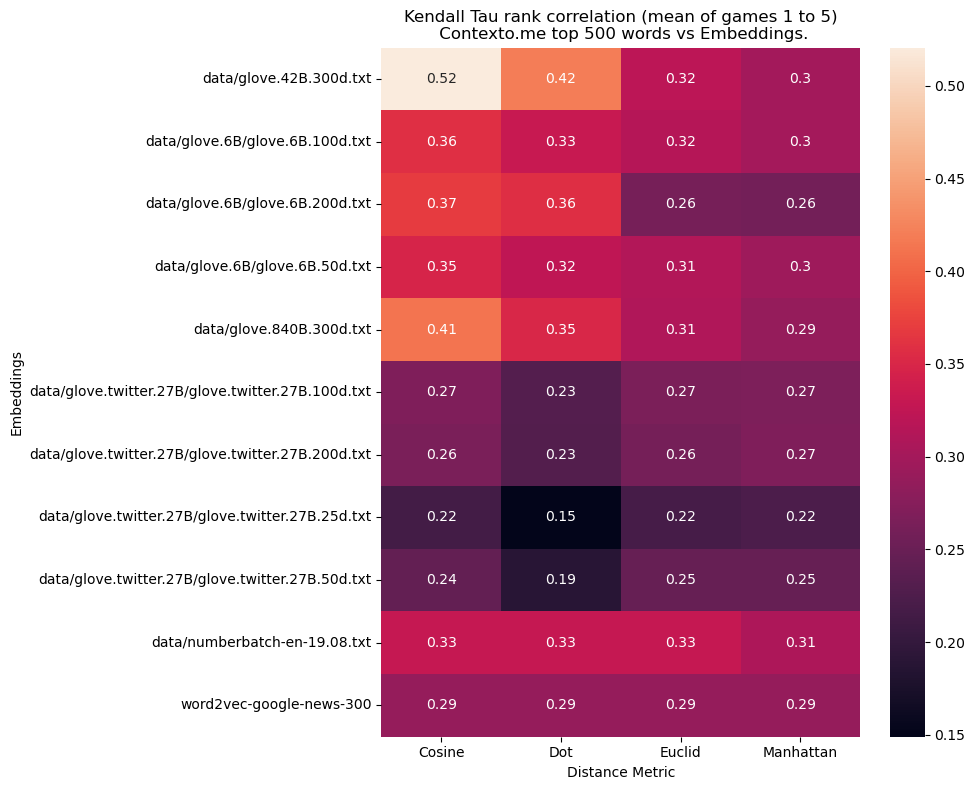

In [52]:
# Make a heatmap of the results
df = pd.read_csv("data/embeddings_correlation.csv")
df_matrix = df.pivot_table(index="glove_fp", columns="distance_metric", values="kendall_tau", aggfunc="mean")
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10, 8))
sns.heatmap(df_matrix, annot=True)
plt.xlabel("Distance Metric")
plt.ylabel("Embeddings")
plt.title("Kendall Tau rank correlation (mean of games 1 to 5)\n Contexto.me top 500 words vs Embeddings.")
plt.tight_layout()
plt.savefig("img/kendall_tau_correlation.png")
plt.show()


## Conlusion

The clear winner is the 42B 300d glove with cosine distance. But it is far from a perfect correlation. There must be a better model/embedding space.

### Follow up

Try to find information in the internet about which vector space was actually used.

Found https://github.com/qdrant/contexto/blob/master/contexto/prepare_embeddings.py that uses 'word2vec-google-news-300'. Go back and check how good this one is. -> Not any better than Glove 42B 300d

This one is also mentioned in a reddit post and multilingual so maybe worth to try ConceptNet Numberbatch 19.08: https://conceptnet.s3.amazonaws.com/downloads/2019/numberbatch/numberbatch-19.08.txt.gz

Also not better than Glove 42B 300d.

Therefore, keep Glove 42B 300d.


# What is the set of words used in the game?

A comprenhensive list of english words is available below, but it contains many words that are not in the game.

http://gwicks.net/textlists/english3.zip (190k words)

From the Qdrant repo, it is unspecified how the words in the file below were obtained. 

https://github.com/qdrant/contexto/blob/master/data/words.txt (10k words)

After playing the game with the bot with the 190k dictionary, many excluded words were found:

[Excluded words](data/excluded_words.txt) (400 words and growing).

To level the ground, I checked the top words for all the games to get a more constrained 
search space where the target words up to game 965 are a strict subset of it.

The output is a list of 32k words that is used by default for further development.

[Included words](data/included_words_unique.txt) (32k words)

In [30]:
from tqdm import tqdm
for game_id in tqdm(range(965)):
    try:
        top_words = client.top_words(game_id)
        with open(f"data/included_words_with_duplicates.txt", "a") as f:
            f.write("\n".join(top_words))
    except Exception as e:
        print(f"Error getting top words for game {game_id}: {e}")


100%|██████████| 965/965 [08:44<00:00,  1.84it/s]


In [32]:
# Make the list of words unique
words = list(set(map(str.strip, open("data/included_words_with_duplicates.txt").readlines())))

# Save the list of words
with open("data/included_words.txt", "w") as f:
    f.write("\n".join(sorted(words)))

# Remove the duplicated file
import os
os.remove("data/included_words_with_duplicates.txt")



# Conclusion

The dictionary in the game has at least 32k words. Let's keep the ones extracted for now.

# Adding heuristics for common words.

I noticed that many target words are a lot more common than the suggestions from the
uninformed strategies. Curate some information about their frequency to make it available
as metadata in the vector space.

There is a list of the top 5000 most common words available in the link below.

In [61]:
if DOWNLOAD:
    ! wget https://www.wordfrequency.info/samples/wordFrequency.xlsx -O data/common_words.xlsx
else:
    print("Skipping download.")

Skipping download.


In [ ]:
# prepare the common words
df = pd.read_excel("data/common_words.xlsx", sheet_name="1 lemmas")
df = df[['lemma', 'freq']]

df['freq'] = df['freq']/df['freq'].max()

df.to_csv("data/common_words.csv", index=False)